In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

In [2]:
df_abalone = pd.read_csv('data/abalone.csv')

# 이상치 탐색


머신러닝 모델을 이용한 이상치 탐색을 알아 봅니다.

**이상치 탐색(Outlier detection) vs. 신규성 탐색(Novelty detection)**

- 이상치 탐색(Outlier detection): 주어진 데이터 내에서 데이터의 주요 특성과 상이한 극단적 데이터를 탐지합니다. 


- 신규성 탐색(Novelty detection): 새로 주어진 데이터들 중에서 기존 데이터의 특성과 상이한 데이터를 탐지합니다.

## 이상치 탐지용 모델

### Local Outlier Factor(LOF) 

**기본 아이디어**

밀도 기반의 이상치 탐색 방법입니다. 주변의 이웃과 밀도 비율을 계산하여 데이터 포인트의 이상치 점수를 산정하여 판별합니다.


#### 개념

1.$\text{k-distance}(A)$: 데이터 포인트 A를 기준으로, k개의 최근접 포인트까지의 거리입니다. 

> ex) $\text{3-distance(A)}$: A와 3번째로 가까운 포인트와의 거리

2.$N_k(A)$: $\text{k-distance}$(A) 안에 들어온 데이터 개수입니다.(tie 존재하는 경우 k보다 커집니다) 

> ex) $N_3(A) = 3$ : A와 $\text{3-distance}$(A) 안에 있는 데이터 수

3.$\text{RD(Reachability Distance}(A, B) = max\{\text{k-distance}(B), dist(A, B)\}$

> A와 B가 k-distance(B) 보다는 밀접한 거리에 있으면 k-distance(B) 만큼만 배정하여 지나치게 작은 값이 책정되지 않게 합니다.


k = 3 일 때의 예시입니다. 

$3\_distance(A) = \overline{{AB}}$

$N_3(A) = 3$

$RD(B, A) = RD(C, A) = \overline{{AB}}, RD(D, A) = \overline{{AD}}$  입니다.

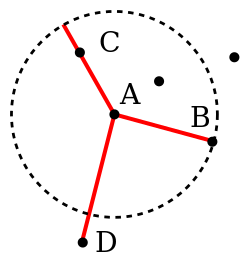

※ 이미지 출처: https://en.wikipedia.org/wiki/Local_outlier_factor

4. Local Reachablility Density(LRD)
> $LRD(A) = \frac{1}{\sum_{B \in N_k(A)} RD(A, B) / N_k(A)}$

- A가 A와 가까운 B들 사이에서 얼마나 떨어져 있는지 측정합니다


- A가 주변 데이터에서 많이 떨어져 있을 수록 LRD는 작아집니다.


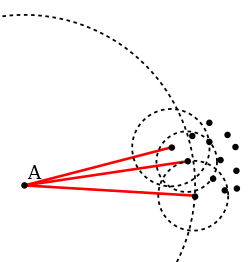

※ 이미지 출처: https://en.wikipedia.org/wiki/Local_outlier_factor

5. Local Outlier Factor(LOF)

LOF는 이웃의 평균 로컬 도달 가능성 밀도를 객체 자체의 로컬 도달 가능성 밀도로 나눈 값입니다.

> $LOF_k(A) = \frac{1}{N_k(A)}\sum_{B \in N_k(A)}{\frac{LRD(B)}{LRD(A)}}$


- $LOF(k) \sim 1$: k의 이웃과 밀도가 유사함을 의미합니다.


- $LOF(k) < 1$: k의 이웃보다 밀도가 높다는 것을 의미합니다. (inlier)


- $LOF(k) > 1$: k의 이웃보다 밀도가 낮다는 것을 의미합니다. (이상치).



**[Ex.1]**

LOF 모델의 동작을 확인해보기 위해서, 3개의 중심점을 가진 2차원 데이터셋을 만듭니다.

최근접 이웃의 수는 3개로 합니다 $LOF_3$를 구하는 과정을 살펴보고, 결과를 시각화해봅니다.

In [3]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=[25, 25, 10], centers=[[0, 0], [3.5, 3.5], [0, 0]], cluster_std=[1, 1, 4], random_state=123)

In [4]:
from scipy.spatial.distance import pdist, squareform
k = 3
dist = squareform(pdist(X)) # 데이터 포인트 간 거리 행렬을 만듭니다.
k_dist = np.sort(dist, axis=0)[k] # k-distance를 계산합니다.가장 작은 자기자신과의 거리는 제외하여, k + 1 번째의 거리를 취합니다.
n_k = np.sum(dist <= k_dist, axis=0) - 1 # 무조건 포함되는 자기자신은 제외합니다.
rd = np.where(dist > k_dist, dist, k_dist) # Reachable distance를 계산합니다.

In [5]:
idx_sort = np.argsort(dist, axis=1)
# 동점은 존재하지 않는 다고 가정하고 n_k 계산은 하지않고 모두, n_k = 3이라고 전제합니다.
# k개의 이웃 구합니다. 가장 거리가 가까운 자기 자신은 제외합니다. 
# n × 3 개의 행렬로  이웃의 인덱스를 지니고 있습니다. 인접한 순으로 정렬되었습니다.
kneighbors = idx_sort[:, 1:(k + 1)] 
# 이웃과의 거리를 구합니다. n × 3 이웃과의 거리를 지니고 있습니다 인접한 순으로 정렬이 되었습니다.
neighbor_dist = np.vstack([dist[i, kneighbors[i]] for i in range(idx_sort.shape[0])]) 
kdist = neighbor_dist[:, -1] # k-dist는 k번째로 멀리 떨어져 있는 이웃의 거리입니다.
# np.maximum(neighbor_dist, kdist[kneighbors])로 reachable distance를 구합니다.
lrd = 1 / np.mean(np.maximum(neighbor_dist, kdist[kneighbors]), axis=1)
# lof를 계산합니다.
lof = np.mean(lrd[kneighbors] / np.expand_dims(lrd, axis=-1), axis=1)

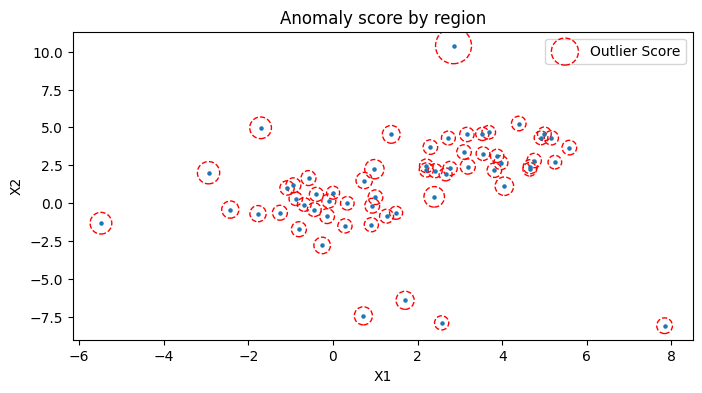

In [6]:
plt.figure(figsize=(8, 4))
# 분류 평면 시각화
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))
plt.scatter(X[:, 0], X[:, 1], s=100 * lof, color='r', facecolors='none', label='Outlier Score',  linestyle='--')
plt.scatter(X[:, 0], X[:, 1], s=5)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Anomaly score by region')
plt.legend()
plt.show()

#### 특징

- 모든 데이터를 고려하지 않고, 해당 포인트의 주변 데이터만을 이용한 이상치 탐지를 합니다.


- 데이터의 분포나 밀도를 가정하지 않기 때문에 다양한 유형의 데이터에 적용할 수 있습니다.


- 이상치의 유무를 이상치 점수의 임계값을 기준으로 결정합니다. 임계값은 데이터나 분석 목적에 따라 조정이 필요합니다.


- 이웃의 수를 결정하는 것은 LOF의 성능에 영향이 큽니다. 따라서 적정한 이웃수를 정하기 위한 최적화 과정이 동반되어야 합니다.


**sklearn.neighbors.LocalOutlierFactor**

**주요 하이퍼파라메터**

|이름|설명|
|---|:-----|
|n_neighbors|최근접 이웃의 수|
|novelty|모델 동작 설정<br/> True: 신규성 탐색(novelty detection) 학습데이터를 바탕으로 주어진 데이터 포인트들이 신규성이 있는지 탐색합니다.<br/> False: 학습데이터 중에서 주요 특성에서 벗어난 이상치 탐색(outlier detection)을 합니다.|


**[Ex.2]**

df_abalone 데이터에서 성별(Sex)로 구분하여 LOF(Local Outlier Factor) 모델을 사용하여 이상치 탐색을 합니다. 


성별(Sex)를 제외한 나머지 변수들의 입력 변수로 합니다.

결과는 성별(Sex)로 입력변수를 2차원으로 차원 축소하여 시각화해봅니다. 

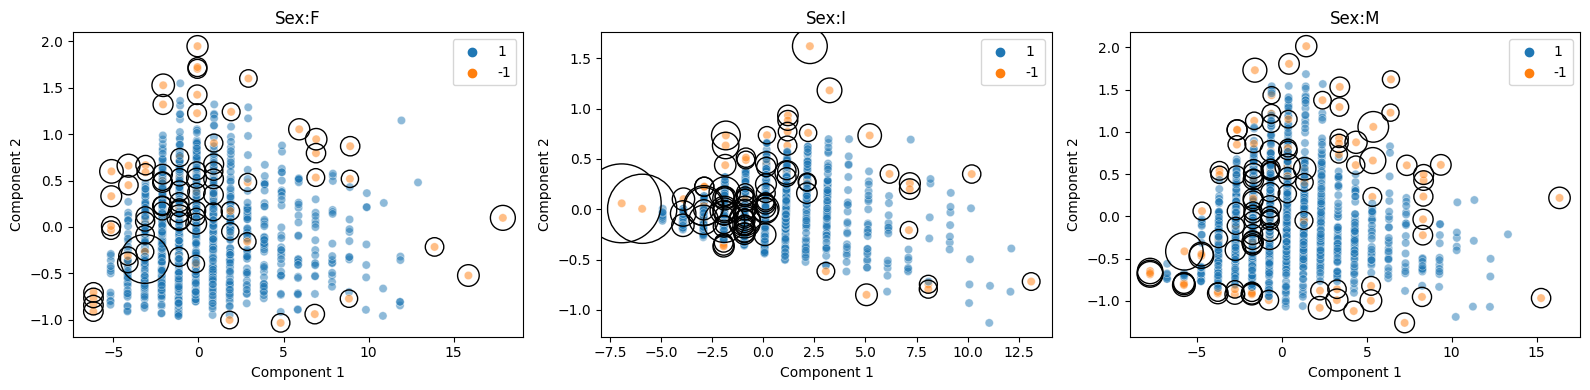

In [7]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

n_neighbors = 5
pca = PCA(n_components=2, random_state=123)
X_cols = [i for i in df_abalone.columns if i != 'Sex']
for ax, (k, df) in zip(axes, df_abalone.groupby('Sex')):
    lof = LocalOutlierFactor(n_neighbors=5, contamination='auto')
    is_outlier = lof.fit_predict(df[X_cols])
    X_pca = pca.fit_transform(df[X_cols])
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=is_outlier.astype(str), ax=ax, alpha=0.5),
    ax.scatter(X_pca[is_outlier == -1, 0], X_pca[is_outlier == -1, 1], 
               s=-lof.negative_outlier_factor_[is_outlier == -1] *  100, facecolors='none', color='k')
    ax.set_title('Sex:{}'.format(k))
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
plt.tight_layout()
plt.show()

### Isolation Forest

의사 결정 나무와 앙상블 기법을 결합하여 만들어진 이상치 탐지 모델입니다.

#### 기본 아이디어

- 임의의 변수를 선택하고 최소값과 최대값 사이의 임의 지점에서 좌우로 분할하여 의사 결정 나무를 성장 시킵니다. 이 의사 결정 나무를 iTree라고 합니다.


- 이상치에 해당하는 것은 비교적 짧은 경로를 통해서 분리가 된다는 점을 이용합니다.


- 앙상블 기법을 응용하여 여러 iTree의 결과를 종합해서 이상치 점수를 종합하여 이상치 여부를 판별합니다. 


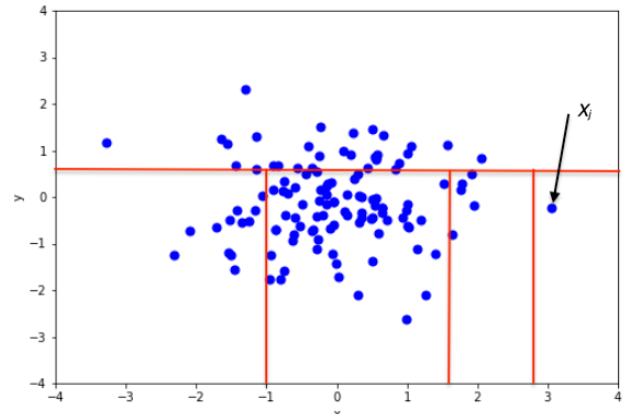

####  iTree 학습

1. Sub-sampling: 전체 데이터셋의 일부를 샘플링합니다.

2. 노드를 분기 시킵니다. 

> 임의의 변수를 선택합니다. 이를 A라고 합니다.
>
> A의 최대값과 최소값 사이의 임의의 점을 uniform하게 선택하여 분기 시킵니다.

3. 1~2 과정을 종료 조건을 만족시킬 때까지 반복합니다.

> 사전에 설정한 나무의 최대 깊이에 도달했을 경우
>
> 데이터 포인트가 하나만 존재하거나, 모든 값이 같은 경우

**[Ex.3]**

IsolationForest의 iTree를 만드는 과정을 확인해봅니다

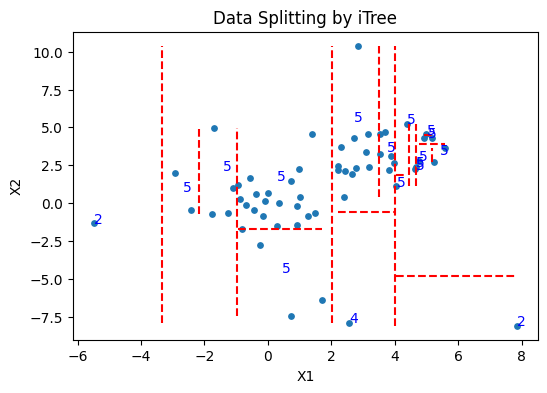

In [9]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=[25, 25, 10], centers=[[0, 0], [3.5, 3.5], [0, 0]], cluster_std=[1, 1, 4], random_state=123)

def recursive_split(X, depth=0, max_depth=3, ax=None):
    # 최대 깊이 도달 하거나, 데이터가 하나만 남으면 종료 시킵니다.
    if depth >= max_depth or len(X) <= 1:
        if ax is not None:
            ax.text(
                (X[:, 0].min() + X[:, 0].max()) *0.5,
                (X[:, 1].min() + X[:, 1].max()) *0.5, str(depth), color='blue'
            )
        return
    
    split_targets = list()
    # X1, X2 두 개의 변수만을 고려합니다.
    for i in range(2):
        mn, mx = X[:, i].min(), X[:, i].max()
        # 유일값이 아닐 경우 분기 시킵니다.
        if mn < mx:
            split_targets.append((i, mn, mx))
    # 분기할 변수가 없으면 종료합니다.
    if len(split_targets) == 0:
        ax.text(
            (X[:, 0].min() + X[:, 0].max()) *0.5,
            (X[:, 1].min() + X[:, 1].max()) *0.5, str(depth), color='blue'
        )
        return
    split_target = split_targets[np.random.randint(0, len(split_targets), 1)[0]]
    threshold = np.random.uniform(split_target[1], split_target[2])
    idx = split_target[0]
    # 데이터를 좌우측으로 분할합니다.
    X_left,  X_right =  X[X[:, idx] < threshold], X[X[:, idx] >= threshold]
    if ax != None:
        if idx == 0:
            ax.add_line(Line2D((threshold, threshold), (X[:, 1].min(), X[:, 1].max()), color='r', linestyle='--'))
        else:
            ax.add_line(Line2D((X[:, 0].min(), X[:, 0].max()), (threshold, threshold), color='r', linestyle='--'))
    
    # 왼쪽과 오른쪽 데이터에 대해 재귀적으로 분할합니다.
    recursive_split(X_left, depth + 1, max_depth, ax)
    recursive_split(X_right, depth + 1, max_depth, ax)

plt.figure(figsize=(6, 4))
np.random.seed(123)
# 재귀적으로 데이터 분할 및 시각화
recursive_split(X, max_depth=5, ax = plt.gca())

plt.scatter(X[:, 0], X[:, 1], s=15)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Data Splitting by iTree')
plt.show()

#### 이상치 점수(Anomaly Score)

- 데이터 포인트의 이상치 정도를 나타내는 점수입니다. 

> $s(x, n) = 2^{-\frac{E[h(x)]}{c(n)}}$
>
> $h(x)$: 데이터 포인트 x의 iTree 경로 길이, 경로의 길이가 짧을 수록 이상치일 가능성이 높습니다.
>
> $E[h(x)]$: 모든 iTree에서 데이터 포인트에 대한 평균 경로 길이
>
> $c(n)$: $h(x)$를 정규화하기 위한 값으로, iTree의 평균 길이

- E(h(x))가 작을 수록 이상치일 확률이 높습니다, s(x)가 클수록 이상치일 가능성은 높게 됩니다.

**sklearn.ensemble.IsolationForest**

**주요 하이퍼파라메터**

|이름|설명|
|---|:-----|
|n_estimators|iTree의 수|
|m_samples|iTree의를 학습 시킬 때, 사용할 데이터의 수 <br/> 정수이면 개수 <br/> 0과 1사이 수 이면 비율|
|bootstrap|복원추출 여부, True: 복원 추출, False: 비복원 추출|


**[Ex.4]**

IsolationForest의 동작을 확인할 수 있는 간단한 데이터를 만들어 이상치의 판별과, 이상치 점수 분포를 시각화하여, 

IsolationForest 모델의 특성을 확인해봅니다.

In [10]:
from sklearn.ensemble import IsolationForest
from sklearn.tree import plot_tree
isf = IsolationForest(
    n_estimators=200, 
    max_samples=0.9, 
    contamination="auto", 
    behaviour='new', random_state=12)
prd = isf.fit_predict(X)
prd

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1, -1, -1, -1,  1, -1, -1, -1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1])

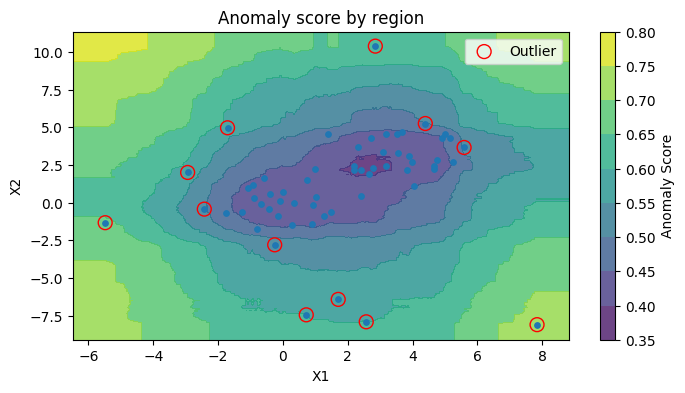

In [11]:
plt.figure(figsize=(8, 4))
# 분류 평면 시각화
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))
Z = -(isf.decision_function(np.c_[xx.ravel(), yy.ravel()]) + isf.offset_)
Z = Z.reshape(xx.shape)
contour = plt.contourf(xx, yy, Z, alpha=0.8)
cbar = plt.colorbar(contour)
cbar.set_label('Anomaly Score')

X_outlier = X[prd == -1]
plt.scatter(X_outlier[:, 0], X_outlier[:, 1], s=100, color='r', facecolors='none', label='Outlier')
plt.scatter(X[:, 0], X[:, 1], s=15)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Anomaly score by region')
plt.legend()
plt.show()

#### 특징

- 데이터 분포에 대한 가정이 필요없습니다.


- 고차원 데이터에서도 성능 저하가 거리 기반 모델보다 덜 합니다.


- 데이터의 수와 iTree의 개수에 따라 결과가 불안정합니다.

**[Ex.5]**

[Ex.2]에서 LOF 대신 IsolationForest를 사용해봅니다.

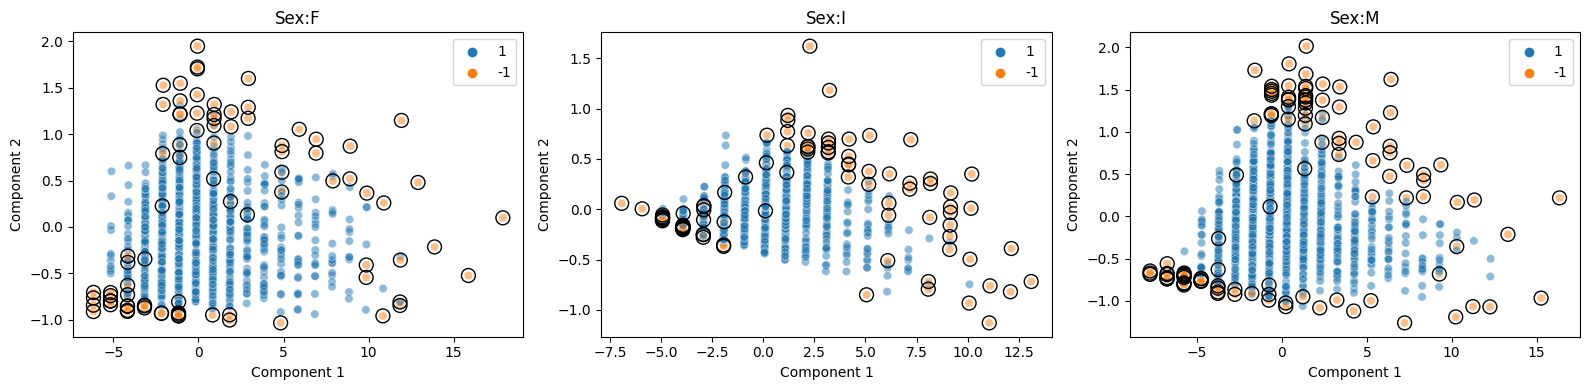

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

pca = PCA(n_components=2, random_state=123)
X_cols = [i for i in df_abalone.columns if i != 'Sex']
for ax, (k, df) in zip(axes, df_abalone.groupby('Sex')):
    isf = IsolationForest(max_samples=0.9, contamination='auto', behaviour='new', random_state=12)
    is_outlier = isf.fit_predict(df[X_cols])
    X_pca = pca.fit_transform(df[X_cols])
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=is_outlier.astype(str), ax=ax, alpha=0.5),
    ax.scatter(X_pca[is_outlier == -1, 0], X_pca[is_outlier == -1, 1], s=100,
               facecolors='none', color='k')
    ax.set_title('Sex:{}'.format(k))
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
plt.tight_layout()
plt.show()

## 일반 모델의 이상치 탐지 응용

### PCA


#### 기본 아디어

PCA를 통해 차원 축소후에 다시 값을 복원하여 원래값과의 차이를 비교합니다. 

> PCA는 데이터가 지닌 선형관계에서 분산설명력을 유지한 상태서 변수들이 서로 독립이 되도록하는 선형 변환으로 
>
> 적은 변수로 최대한의 변동성을 설명하는 성분들을 만들어줍니다. 
>
> 이 과정에서 전반적인 데이터의 특성을 따르지 않는 변수들은 차원을 축소했을 때, 상대적으로 손실이 크게됩니다. 
>
> 손실의 양을 통해 이상치를 판별합니다.

**[Ex.6]**

df_avalone 모델을 성별(Sex)로 구분하여 2개의 주성분(약 99.9%의 변동성이 설명됩니다.)으로 차원축소를 합니다.

이 때, 성별(Sex)을 제외하고 다른 모든 변수를 입력 변수로 합니다.

1개의 주성분을 다시 원래 차원으로 역변환했을 때, 원래값과 유클리디언 거리룰 계산합니다.

이 거리가 큰 것을 기준으로 상위 1% 이상인 데이터들을 이상치로 간주합니다. 이상치를 판별하여 **[Ex.2]** 처럼 시간화해봅니다.

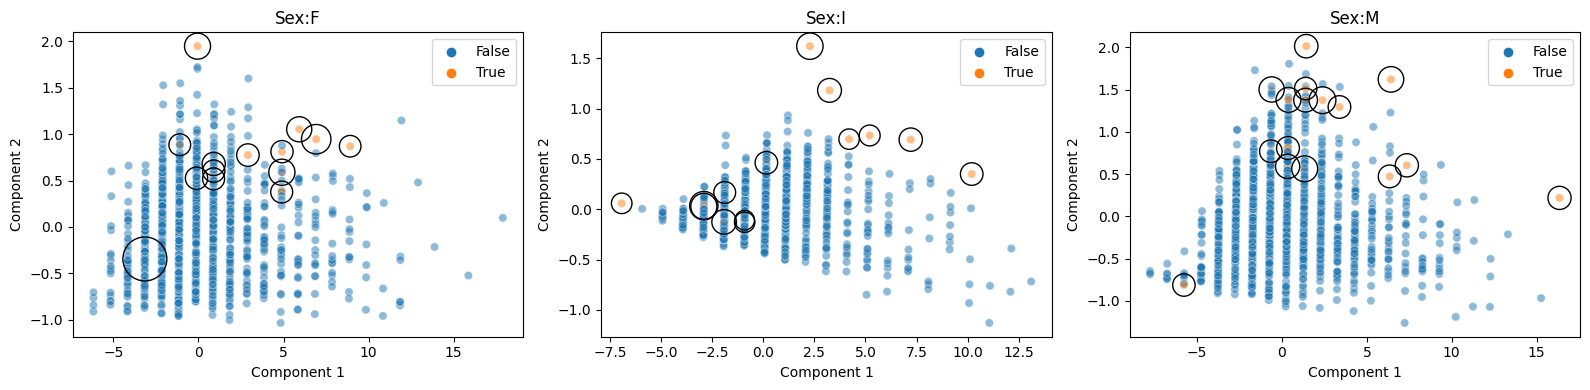

In [13]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

pca = PCA(n_components=2, random_state=123)
X_cols = [i for i in df_abalone.columns if i != 'Sex']
for ax, (k, df) in zip(axes, df_abalone.groupby('Sex')):
    X_pca = pca.fit_transform(df[X_cols])
    # PCA 역변환을 합니다. PCA 설정이 주성분을  2개를 뽑는 것이었으니, 2개의 성분에 대한 역변환이 수행됩니다.
    X_inv = pca.inverse_transform(X_pca) 
    X_diff = np.sum(np.square(X_inv - df[X_cols]), axis=1) ** 0.5
    thres = np.quantile(X_diff, 0.99)
    is_outlier = X_diff >= thres
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=is_outlier, ax=ax, alpha=0.5),
    X_pca_outlier = X_pca[is_outlier]
    ax.scatter(X_pca_outlier[0], X_pca_outlier[1], s=X_diff[is_outlier] * 1000,  facecolors='none', color='k')
    ax.set_title('Sex:{}'.format(k))
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
plt.tight_layout()
plt.show()

### DBSCAN


군집화 알고리즘인 DBSCAN은 어떠한 군집에도 속하지 않은 노이즈(Noise) 포인트가 있습니다. 이상치 탐색에서는 이 노이즈 포인트를 이상치로 판별할 수 있습니다.

**[Ex.7]** 

df_avalone을 성별(Sex)로 DBSCAN으로 군집화하고 어떠한  군집에도 소속되지 않은 데이터포인트들을 [Ex.2] 처럼 PCA로 2차원으로 줄여 표시해봅니다.

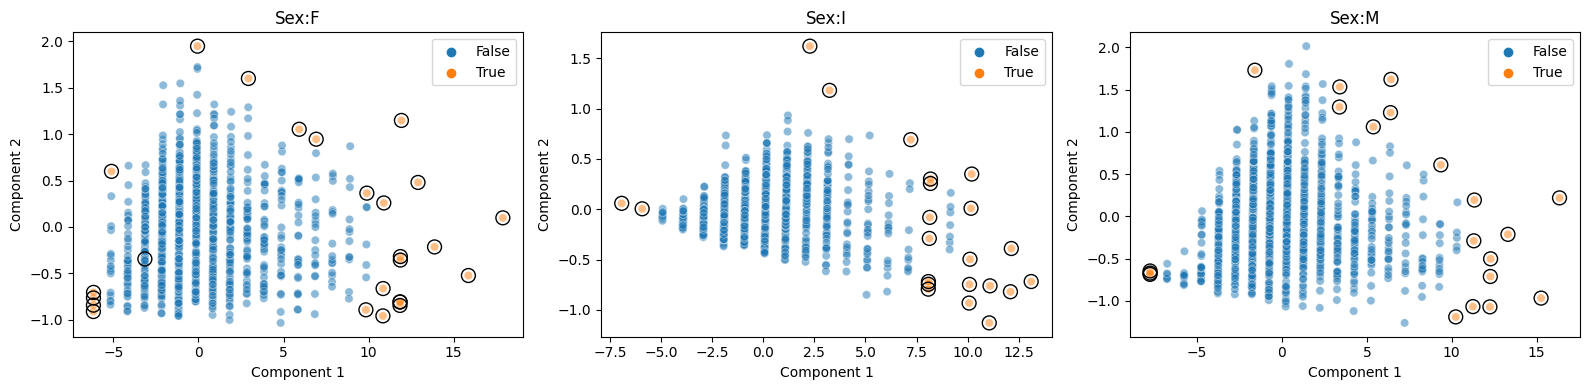

In [14]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

X_cols = [i for i in df_abalone.columns if i != 'Sex']
for ax, (k, df) in zip(axes, df_abalone.groupby('Sex')):
    dbscan = DBSCAN()
    clu = dbscan.fit_predict(df[X_cols])
    X_pca = pca.fit_transform(df[X_cols])
    
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clu == -1, ax=ax, alpha=0.5),
    ax.scatter(X_pca[clu == -1, 0], X_pca[clu == -1, 1], s= 100,  facecolors='none', color='k')
    ax.set_title('Sex:{}'.format(k))
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
plt.tight_layout()
plt.show()